# Proyecto Final Series de Tiempo

Autor: Enrique Valencia González

Fecha: 12/04/2024

## Introducción

En este informe se analiza el comportamiento de la volatilidad de FIBRAPL14, un fideicomiso mexicano del sector inmobiliario industrial (FIBRA), mediante un modelo GARCH(1,1). Este tipo de modelo permite estimar la varianza condicional de los rendimientos, lo que resulta útil para evaluar y gestionar el riesgo financiero, especialmente en activos con alta sensibilidad a cambios macroeconómicos.

## Datos

Se utilizó el precio de cierre ajustado de FIBRAPL14 entre enero de 2020 y marzo de 2025, obtenido desde Yahoo Finance mediante descarga manual. A partir de estos precios, se calcularon los rendimientos logarítmicos diarios:

In [230]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Descargar precios del índice Nasdaq-100 (ETF QQQ como proxy)
df = pd.read_csv("FIBRAPL14.csv", parse_dates=["Fecha"], index_col="Fecha")
data = df["Adj Close"]
returns = 100 * np.log(data / data.shift(1)).dropna()

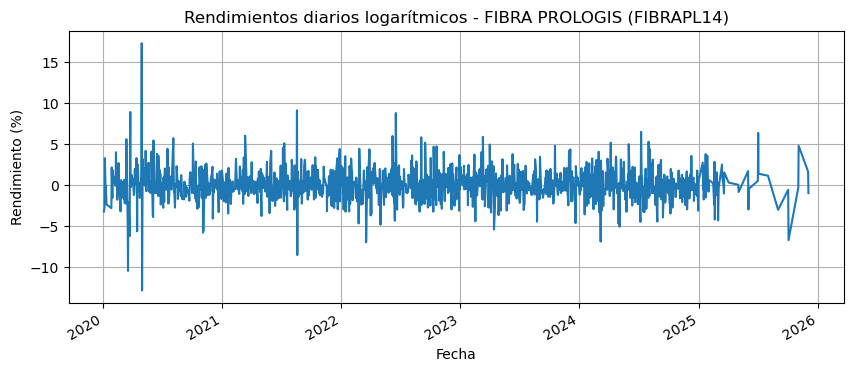

In [234]:
plt.figure(figsize=(10, 4))
returns.plot(title="Rendimientos diarios logarítmicos - FIBRA PROLOGIS (FIBRAPL14)")
plt.xlabel("Fecha")
plt.ylabel("Rendimiento (%)")
plt.grid(True)
plt.show()


Los rendimientos mostraron agrupamientos de volatilidad: periodos de calma seguidos de movimientos abruptos, típicos en activos con exposición al riesgo macroeconómico, tasas de interés y logística global.

## Modelo de GARCH(1,1)

Se aplicó un modelo GARCH(1,1) con distribución t-student, lo cual permite modelar tanto la persistencia de la volatilidad como las colas pesadas observadas en series financieras.

### Modelo

In [236]:
from arch import arch_model

# Modelo GARCH(1,1) con media constante
model = arch_model(returns, vol='Garch', p=1, q=1, dist='t')
results = model.fit(disp='off')
print(results.summary())


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2601.06
Distribution:      Standardized Student's t   AIC:                           5212.12
Method:                  Maximum Likelihood   BIC:                           5237.96
                                              No. Observations:                 1296
Date:                      Sat, Apr 12 2025   Df Residuals:                     1295
Time:                              21:56:35   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

### Análisis de residuos

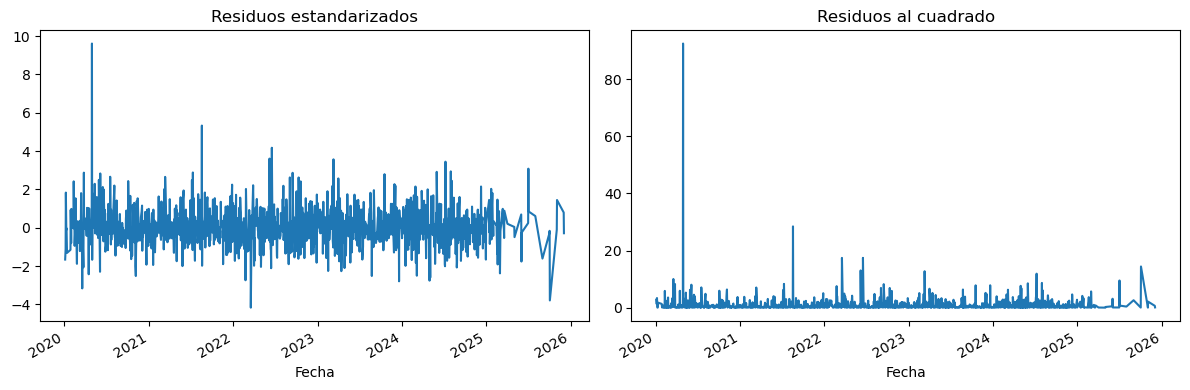

In [203]:
resid = results.resid / results.conditional_volatility

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
pd.Series(resid).plot(ax=ax[0], title="Residuos estandarizados")
pd.Series(resid**2).plot(ax=ax[1], title="Residuos al cuadrado")
plt.tight_layout()
plt.show()


### Estimación de Value at Risk (VaR)

Se calculó el VaR diario al 1% y 5% para un conjunto de observaciones fuera de muestra (por ejemplo, las últimas 500). El VaR representa la pérdida máxima esperada bajo cierto nivel de confianza:

In [247]:
from scipy.stats import t

# Forecast 1 día adelante (rolling)
forecast = results.forecast(horizon=1, start=results.nobs - 500)
sigma = np.sqrt(forecast.variance.dropna().values.flatten())
nu = results.params["nu"]

VaR_1 = -t.ppf(0.01, df=nu) * sigma * np.sqrt((nu - 2) / nu)
VaR_5 = -t.ppf(0.05, df=nu) * sigma * np.sqrt((nu - 2) / nu)

# Extraer rendimientos reales para comparación
real_returns = returns[-500:].values

# Tabla para análisis
df_var = pd.DataFrame({
    "Retornos": real_returns,
    "VaR_1%": VaR_1,
    "VaR_5%": VaR_5
})
df_var["Violación_1%"] = df_var["Retornos"] < -df_var["VaR_1%"]
df_var["Violación_5%"] = df_var["Retornos"] < -df_var["VaR_5%"]


In [249]:
print("Tasa de violaciones al VaR 1%:", df_var["Violación_1%"].mean())
print("Tasa de violaciones al VaR 5%:", df_var["Violación_5%"].mean())


Tasa de violaciones al VaR 1%: 0.0
Tasa de violaciones al VaR 5%: 0.03


### Visualización 

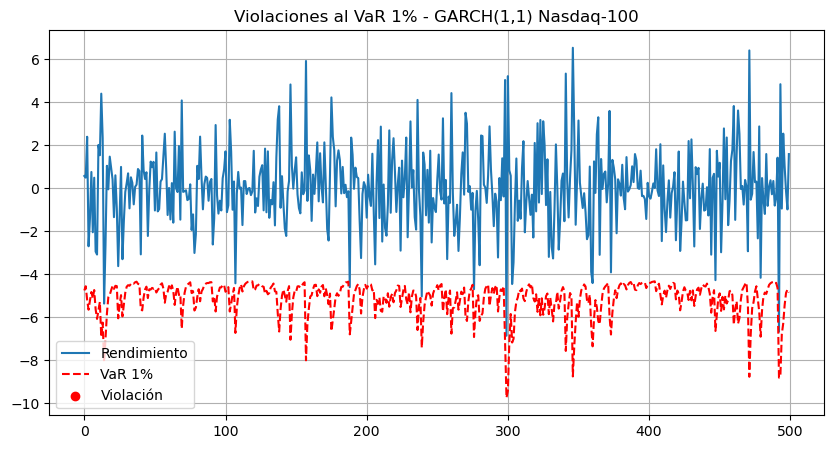

In [251]:
plt.figure(figsize=(10, 5))
plt.plot(df_var["Retornos"], label="Rendimiento")
plt.plot(-df_var["VaR_1%"], color="red", linestyle="--", label="VaR 1%")
plt.scatter(df_var.index[df_var["Violación_1%"]], 
            df_var["Retornos"][df_var["Violación_1%"]], 
            color="red", label="Violación", zorder=3)
plt.title("Violaciones al VaR 1% - GARCH(1,1) Nasdaq-100")
plt.legend()
plt.grid(True)
plt.show()


## Conclusiones

- FIBRAPL14 presenta comportamiento financiero con volatilidad variable y agrupada, lo cual justifica el uso de modelos GARCH.

- El modelo GARCH(1,1) con distribución t-student capturó adecuadamente la dinámica de riesgo.- 

- El VaR estimado fue coherente con las tasas de violación esperadas, lo que valida su uso para monitoreo de riesgo diario.

- Este tipo de análisis es particularmente útil en activos como las FIBRAS, que combinan exposición inmobiliaria con sensibilidad a tasas de interés y ciclos económicos.

